In [2]:
# import modules
import kagglehub
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
    import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from scipy import stats

In [3]:
# Download latest version
path = kagglehub.dataset_download("vikrishnan/boston-house-prices")

print("Path to dataset files:", path)

Path to dataset files: /Users/xiang/.cache/kagglehub/datasets/vikrishnan/boston-house-prices/versions/1


In [4]:
dir() # provides a list of objects in a namespace

['In',
 'MS',
 'Out',
 'VIF',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__vsc_ipynb_file__',
 '_dh',
 '_i',
 '_i1',
 '_i2',
 '_i3',
 '_i4',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'anova_lm',
 'exit',
 'get_ipython',
 'kagglehub',
 'load_data',
 'np',
 'open',
 'path',
 'pd',
 'poly',
 'quit',
 'sm',
 'stats',
 'subplots',
 'summarize']

In [5]:
A=np.array([3,4,2,4])
dir(A)
# provides a list of objects in a namespace

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__buffer__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '

In [6]:
print(A.var(), A.mean(), A.sum())


0.6875 3.25 13


### Simple Linear Regression

In [7]:
# Constructing model matrices (or design matrices) using 
# ModelSpec() transform from ISLP.models
Boston = load_data("Boston")
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

- `medv`: median house value
- `rmvar`: average number of rooms per house
- `age`: proportion of owner-occupied units built prior to 1940
- `lstat`: percent of households with low socioeconomic status
etc.


In [8]:
Boston?

Type:        DataFrame
String form:
crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
           0    0.00632  18.0   2.3 <...> 0   5.64  23.9
           504     21.0   6.48  22.0
           505     21.0   7.88  11.9
           
           [506 rows x 13 columns]
Length:      506
File:        /opt/anaconda3/lib/python3.12/site-packages/pandas/core/frame.py
Docstring:  
Two-dimensional, size-mutable, potentially heterogeneous tabular data.

Data structure also contains labeled axes (rows and columns).
Arithmetic operations align on both row and column labels. Can be
thought of as a dict-like container for Series objects. The primary
pandas data structure.

Parameters
----------
data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
    Dict can contain Series, arrays, constants, dataclass or list-like objects. If
    data is a dict, column order follows insertion-order. If a dict contains Series
    which have an index defined, it is aligned by its index

In [9]:
# Fit a simple linear regression model
# dependent variable: medv, independent variable: lstat

X=pd.DataFrame({'intercept':np.ones(Boston.shape[0]),
                'lstat':Boston['lstat']})
X[:4]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


In [10]:
y=Boston['medv'] # extract response
model=sm.OLS(y,X) # specifies the model
results=model.fit() # fit model

In [11]:
summarize(results)

,coef,std err,t,P>|t|
intercept,34.5538,0.563,61.415,0.0
lstat,-0.9500,0.039,-24.528,0.0


### Using Transformations: Fit and Transform

To introduce transformations to the variables before fitting the model, specify interactions between variables, and expand some particular variables into set of variables (e.g. polynomials), we use transforms, an object that is created with some parameters as arguments. 

In [12]:
# create transform
design=MS(['lstat'])
design=design.fit(Boston) 
X=design.transform(Boston)
X[:4]

,intercept,lstat
0,1.0,4.98
1,1.0,9.14
2,1.0,4.03
3,1.0,2.94


`MS()` stands for `ModelSpec()` which is a transform in the `ISLP` library. 

The `fit()` method takes the original array and do some initial computations on it as specified in the transform object, e.g. mean/sd for centering and scaling (?). In this case, it just checks that the variable `lstat` specified in `design` exists in `Boston`.

The `transform()` method applies the fitted transformation to the array of data, and produces the model matrix. In this case it constructs the model matrix with two columns: an `intercept` and the variable `lstat`.

We can combine these two operations by
```
X=design.fit_transform(Boston)
```

In [13]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Sat, 12 Jul 2025   Prob (F-statistic):           5.08e-88
Time:                        17:08:23   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
results.params

intercept    34.553841
lstat        -0.950049
dtype: float64

### Confidence intervals and prediction intervals

In [15]:
# obtain predictions, confidence intervals, prediction intervals:
new_df=pd.DataFrame({'lstat':[5,10,15]})
newX=design.transform(new_df)
newX

,intercept,lstat
0,1.0,5
1,1.0,10
2,1.0,15


In [16]:
new_predictions=results.get_prediction(newX)
new_predictions.predicted_mean 

array([29.80359411, 25.05334734, 20.30310057])

In [17]:
# 95% confidence interval
new_predictions.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

In [18]:
# 95% prediction interval
new_predictions.conf_int(obs=True, alpha=0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

### Defining functions

In [19]:
def abline(ax,b,m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim=ax.get_xlim()
    ylim=[m*xlim[0]+b,m*xlim[1]+b]
    ax.plot(xlim,ylim, *args, **kwargs)

In [20]:
help(abline)

Help on function abline in module __main__:

abline(ax, b, m, *args, **kwargs)
    Add a line with slope m and intercept b to ax



/var/folders/n1/xb4gyj5530g0114s2tcl_l_c0000gn/T/ipykernel_932/248772308.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0],
/var/folders/n1/xb4gyj5530g0114s2tcl_l_c0000gn/T/ipykernel_932/248772308.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[1],


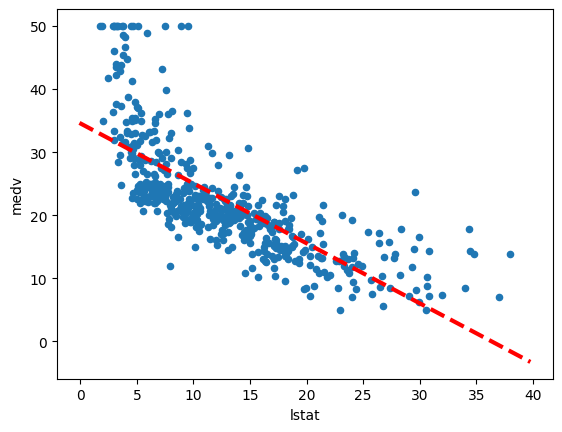

In [21]:
ax=Boston.plot.scatter('lstat','medv')
abline(ax,
       results.params[0],
       results.params[1],
       'r--', #red dashed line
       linewidth=3)

We observe some non-linearity, which we will address later.

---
#### Diagnostic plots

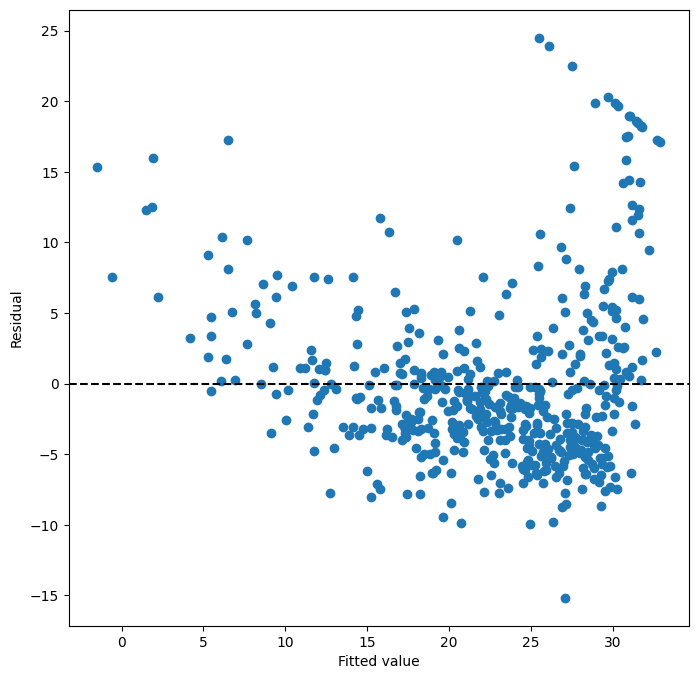

In [22]:
#ax=subplots(figsize=(8,8))[1]

fig,ax=subplots(figsize=(8,8))
ax.scatter(results.fittedvalues,results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0,c='k',ls='--')
# c='k': black color
# ls='--' dashed linestyle

374

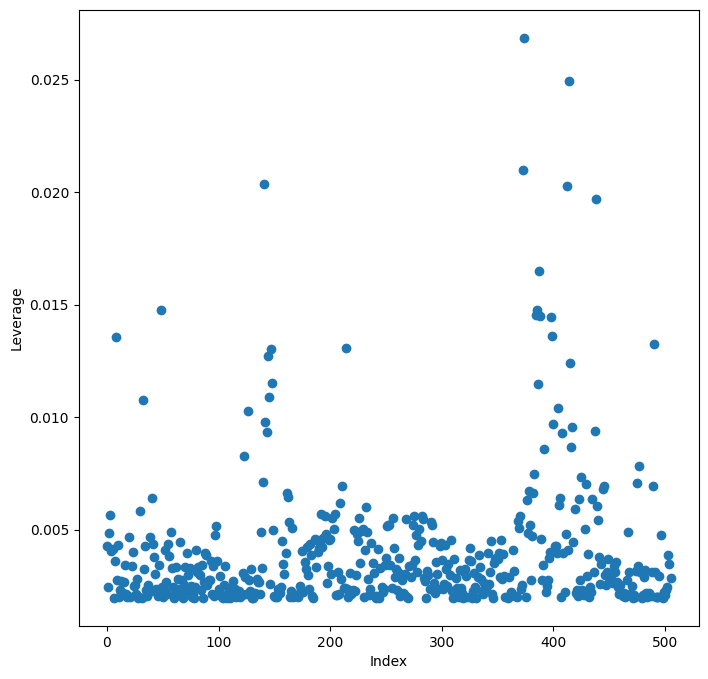

In [23]:
infl=results.get_influence()
fig,ax=subplots(figsize=(8,8))
ax.scatter(np.arange(X.shape[0]),infl.hat_matrix_diag) # hat matrix diag = leverage values
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)
# identify the index of the observation which gives the largest
# leverage statistic

---
### Multiple linear regression

In [24]:
X=MS(['lstat','age']).fit_transform(Boston)
model1=sm.OLS(y,X)
results1=model1.fit()
summarize(results1)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


- both p-values are quite close to zero, so the two predictors are significant. 

- when the percentage of households with low socioeconomic status in the neighbourhood increases by one percent with percentage of owner-occupied units built before 1960 kept constant, the median house value of the neighbourhood decreases by 1.032 units.
- when the percentage of owner-occupied units built before 1960 in the neighbourhood increases by one percent, holding percentage of households with low socioeconomic status constant, the median house value of the neighbourhood increases by 0.0345 units.
- poorer neighbourhoods have lower house prices, older neighbourhoods have slightly higher house prices although the effect is small.

In [25]:
# extract all the variable names from the dataset
terms = Boston.columns.drop('medv')
terms

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat'],
      dtype='object')

In [26]:
X=MS(terms).fit_transform(Boston)
model2=sm.OLS(y,X)
results2=model2.fit()
summarize(results2)

,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


`indus`, `age` have insignificant $p$-values in the multiple regression model. We try to run a regression excluding these predictors:

In [27]:
subset=Boston.columns.drop(['medv','age','indus'])
X_sbst=MS(subset).fit_transform(Boston)
model3=sm.OLS(y,X_sbst)
results3=model3.fit()
summarize(results3)

,coef,std err,t,P>|t|
intercept,41.4517,4.903,8.454,0.000
crim,-0.1217,0.033,-3.696,0.000
zn,0.0462,0.014,3.378,0.001
chas,2.8719,0.863,3.329,0.001
nox,-18.2624,3.565,-5.122,0.000
rm,3.6730,0.409,8.978,0.000
dis,-1.5160,0.188,-8.078,0.000
rad,0.2839,0.064,4.440,0.000
tax,-0.0123,0.003,-3.608,0.000
ptratio,-0.9310,0.130,-7.138,0.000


---

### Multivariate goodness of fit 

Access individual components of `results` by name (`dir(results)` to see what's available). e.g. `results.rsquared` gives $R^2$ and `np.sqrt(results.scale)` gives RSE.

In [28]:
X

,intercept,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,1.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98
1,1.0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14
2,1.0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03
3,1.0,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94
4,1.0,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,1.0,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67
502,1.0,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08
503,1.0,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64
504,1.0,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48


In [29]:
vals=[VIF(X,i) # VIF() takes in one df/arr and one var col index
      for i in range(1, X.shape[1])]
vif=pd.DataFrame({'vif':vals},
                 index=X.columns[1:])
vif

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


---

### Interaction terms

In [30]:
X=MS(['lstat','age',('lstat','age')]).fit_transform(Boston)
model4=sm.OLS(y,X)
summarize(model4.fit())


,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


After including the interaction term, the $p$-value of age became insignificant, but by the hierachical principle, we still include the age term in the model.

---

### Non-linear transformations of the predictors

In [31]:
X=MS([poly('lstat', degree=2),'age']).fit_transform(Boston)
model5=sm.OLS(y,X)
results5=model5.fit()
summarize(results5)

,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


The $p$-value for the quadratic term is close to zero, suggesting that it leads to an improved model.

By default, `poly()` creates a basis matrix for the inclusion in the model matrix whose columns are orthogonal polynomials, designed for stable least squares computations.

Use `anova_lm()` to quantify how much the quadratic fit is superior to the linear fit by testing

$$H_0:\text{ quadratic term is not needed }\quad\text{vs.}\quad H_1:\text{ quadratic model is superior}$$

In [32]:
anova_lm(results1, results5)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


Notice that the $F$ statistic happens to be the square of the $t$-statistic for the quadratic term in the linear model due to the fact that these nested models differ by one d.f. Now, since the $p$-value is close to zero, we have significant evidence that the quadratic term improves the linear model, which agrees with our observation of nonlinearity in the sample data.

If we give `anova_lm()` more than two nested models as input,it will compare every successive pair of models, hence we see `NaN` in the first row. 

In [33]:
print(results5.fittedvalues, results5.resid)

0      33.708731
1      26.394812
2      35.550975
3      37.030349
4      32.173607
         ...    
501    24.774887
502    26.347450
503    34.093894
504    32.220124
505    28.854260
Length: 506, dtype: float64 0      -9.708731
1      -4.794812
2      -0.850975
3      -3.630349
4       4.026393
         ...    
501    -2.374887
502    -5.747450
503   -10.193894
504   -10.220124
505   -16.954260
Length: 506, dtype: float64


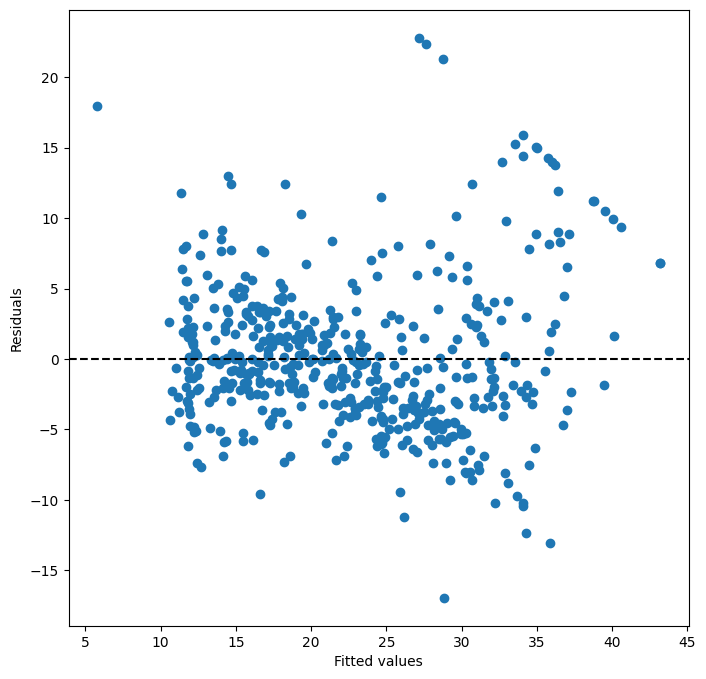

In [34]:
fig,ax=subplots(figsize=(8,8))
ax.scatter(results5.fittedvalues, results5.resid)
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.axhline(0,c='k',ls='--')

---

### Qualitative Predictors

In [35]:
Carseats=load_data('Carseats') # included in the ISLP package
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [36]:
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


From ISLP documentation website:

- `Sales`: Unit sales (in thousands) at each location
- `CompPrice`: Price charged by competitor at each location
- `Income`: Community income level (in thousands of dollars)
- `Advertising`: Local advertising budget for company at each location (in thousands of dollars)
- `Population`: Population size in region (in thousands)
- `Price`: Price company charges for car seats at each site
- `ShelveLoc`: A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
- `Age`: Average age of the local population
- `Education`: Education level at each location
- `Urban`: A factor with levels No and Yes to indicate whether the store is in an urban or rural location
- `US`: A factor with levels No and Yes to indicate whether the store is in the US or not

`ModelSpec()` generates dummy variables automatically for qualitative variables, often referred to as a **one-hot encoding** of the categorical feature.

In [37]:
allvars=list(Carseats.columns.drop('Sales'))
# list converts a pandas.Index object to a Python list
y=Carseats['Sales']
# concatenate the list with a list of tuples
final=allvars+[('Income','Advertising'),
               ('Price', 'Age')] # interaction terms
final

['CompPrice',
 'Income',
 'Advertising',
 'Population',
 'Price',
 'ShelveLoc',
 'Age',
 'Education',
 'Urban',
 'US',
 ('Income', 'Advertising'),
 ('Price', 'Age')]

In [38]:
X=MS(final).fit_transform(Carseats)
model6=sm.OLS(y,X)
results6=model6.fit()
summarize(results6)

,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288


In [39]:
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

## Exercises

### Question 8

This question involves the use of simple linear regression on the `Auto` data set.

(a) Use the `sm.OLS()` function to perform a simple linear regression with `mpg` as the response and `horsepower` as the predictor. Use the `summarize()` function to print the results. Comment on the output. For example:
    
i. Is there a relationship between the predictor and the response?
    
ii. How strong is the relationship between the predictor and the response?
    
iii. Is the relationship between the predictor and the response positive or negative?
    
iv. What is the predicted `mpg` associated with a `horsepower` of 98? What are the associated 95 % confidence and prediction intervals?

(b) Plot the response and the predictor in a new set of axes `ax`. Use
the `ax.axline()` method or the abline() function defined in the
lab to display the least squares regression line.
(c) Produce some of diagnostic plots of the least squares regression
fit as described in the lab. Comment on any problems you see
with the fit.

In [40]:
Auto=load_data('Auto')
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


In [41]:
design=MS(['horsepower'])
design=design.fit(Auto)
X=design.transform(Auto)
y=Auto['mpg']
model7=sm.OLS(y,X)
results7=model7.fit()
summarize(results7)

,coef,std err,t,P>|t|
intercept,39.9359,0.717,55.660,0.0
horsepower,-0.1578,0.006,-24.489,0.0


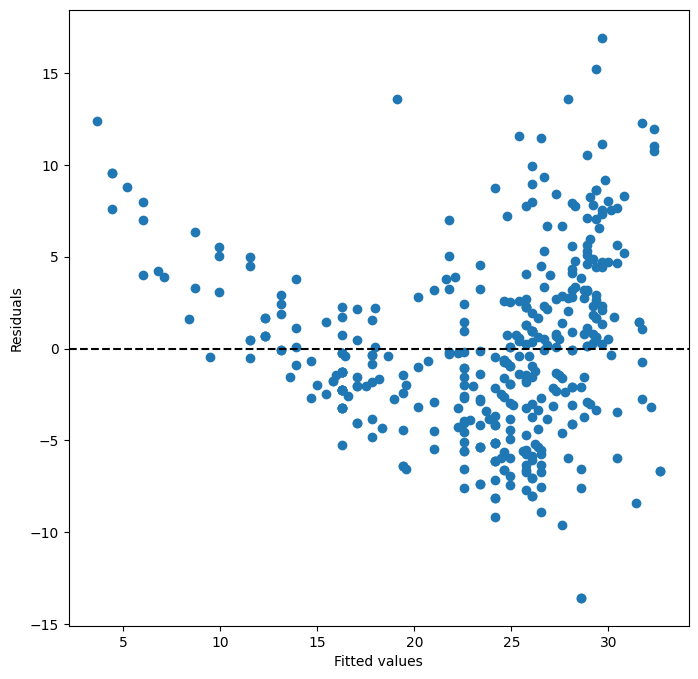

In [42]:
fig,ax=subplots(figsize=[8,8])
ax.scatter(results7.fittedvalues, results7.resid)
ax.set_xlabel("Fitted values")
ax.set_ylabel("Residuals")
ax.axhline(0,c='k',ls='--')

In [43]:
results7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sat, 12 Jul 2025   Prob (F-statistic):           7.03e-81
Time:                        17:08:24   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since the $p$-values of $\beta_1$ estimate is close to 0, horsepower is a significant predictor of mpg. The value of $R^2$ is 0.606, so about 60.6% of the variability in the data is explained by the model. The value of $\beta_1$ is negative, so the relationship between the predictor and response is negative.

In [44]:
new_df2=pd.DataFrame({'horsepower':[98]})
newX2=design.transform(new_df2)
newX2

,intercept,horsepower
0,1.0,98


In [45]:
new_pred=results7.get_prediction(newX2)
new_pred.predicted_mean

array([24.46707715])

In [46]:
# confidence interval
new_pred.conf_int(alpha=0.05)

array([[23.97307896, 24.96107534]])

In [47]:
# prediction interval
new_pred.conf_int(alpha=0.05,obs=True)

array([[14.80939607, 34.12475823]])

---
### Question 10
This question should be answered using the `Carseats` data set.

1. Fit a multiple regression model to predict `Sales` using `Price`, `Urban`, and `US`.

1. Provide an interpretation of each coefficient in the model. Be careful — some of the variables in the model are qualitative!
1. Write out the model in equation form, being careful to handle the qualitative variables properly.
1. For which of the predictors can you reject the null hypothesis $$H_0 : \beta_j = 0?$$
1. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.
1. How well do the models in (1) and (5) fit the data?
1. Using the model from (5), obtain 95 % confidence intervals for the coefficient(s).
1. Is there evidence of outliers or high leverage observations in the model from (5)?

In [48]:
Carseats.head() # data already imported in example

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [49]:
design=MS(['Price','Urban','US'])
design=design.fit(Carseats)
X=design.transform(Carseats)
X

,intercept,Price,Urban[Yes],US[Yes]
0,1.0,120,1.0,1.0
1,1.0,83,1.0,1.0
2,1.0,80,1.0,1.0
3,1.0,97,1.0,1.0
4,1.0,128,1.0,0.0
...,...,...,...,...
395,1.0,128,1.0,1.0
396,1.0,120,0.0,1.0
397,1.0,159,1.0,1.0
398,1.0,95,1.0,1.0


In [50]:
y=Carseats['Sales']
y.head()

0     9.50
1    11.22
2    10.06
3     7.40
4     4.15
Name: Sales, dtype: float64

In [51]:
model8=sm.OLS(y,X)
results8=model8.fit()
summarize(results8)

,coef,std err,t,P>|t|
intercept,13.0435,0.651,20.036,0.000
Price,-0.0545,0.005,-10.389,0.000
Urban[Yes],-0.0219,0.272,-0.081,0.936
US[Yes],1.2006,0.259,4.635,0.000


In [52]:
results8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     41.52
Date:                Sat, 12 Jul 2025   Prob (F-statistic):           2.39e-23
Time:                        17:08:24   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.0435      0.651     20.036      0.000      11.764      14.323
Price         -0.0545      0.005    -10.389      0.000      -0.065      -0.044
Urban[Yes]    -0.0219      0.272     -0.081      0.936      -0.556       0.512
US[Yes]        1.2006      0.259      4.635      0.000       0.691       1.710
==============================================================================
Omnibus:                        0.676   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.758
Skew:                           0.093   Prob(JB):                        0.684
Kurtosis:                       2.897   Cond. No.                         628.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

2. 
- For every thousand dollar increase in price charged by company, the sales decreases by 54.5 dollars holding whether or not the store is in an urban area and whether or not the store is in the US unchanged.
- For every store in an urban area, the sales decreases by 219 dollars keeping the price charged by the company constant and whether or not the store is in the US unchanged.
- For every store in the US, the sales increase by 1200.6 dollars keeping the price charged by the company constant and whether or not the store is in an urban area unchanged.

3. The model equation is $$\hat{Y}=\beta_0+\beta_1X_1+\beta_2X_2+\beta_3X_3+\varepsilon,$$ where $\hat{Y}$ is the estimated sales of carseats in thousands of dollars, $X_1$ represents the price of carseat in thousands of dollars, $X_2$ is a dummy variable which takes a value of 1 if the store is in an urban area and 0 otherwise, $X_3$ is a dummy variable which takes a value of 1 if the store is in the US and 0 otherwise, and $\varepsilon$ is the random error.

4. `Urban`, since it has a significant $p$-value of 0.936 far larger than $\alpha=0.05$.

In [53]:
# Fit a model without Urban

sbst=MS(['Price','US'])
X_sbst=sbst.fit_transform(Carseats)
model9=sm.OLS(y,X_sbst)
results9=model9.fit()
summarize(results9)


,coef,std err,t,P>|t|
intercept,13.0308,0.631,20.652,0.0
Price,-0.0545,0.005,-10.416,0.0
US[Yes],1.1996,0.258,4.641,0.0


In [54]:
results9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Sat, 12 Jul 2025   Prob (F-statistic):           2.66e-24
Time:                        17:08:24   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.0308      0.631     20.652      0.000      11.790      14.271
Price         -0.0545      0.005    -10.416      0.000      -0.065      -0.044
US[Yes]        1.1996      0.258      4.641      0.000       0.692       1.708
==============================================================================
Omnibus:                        0.666   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.749
Skew:                           0.092   Prob(JB):                        0.688
Kurtosis:                       2.895   Cond. No.                         607.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Both models have an $R^2$ value of 0.239 and an adjusted $R^2$ value of about 0.235, so both models explain approximately 23.9% of the variability in the data. Since both models give similar results, we take the reduced model.

7. From the table, the 95% confidence interval for the beta estimate of `Price` and `US` are [11.790,14.271] and [0.692,1.708] respectively.


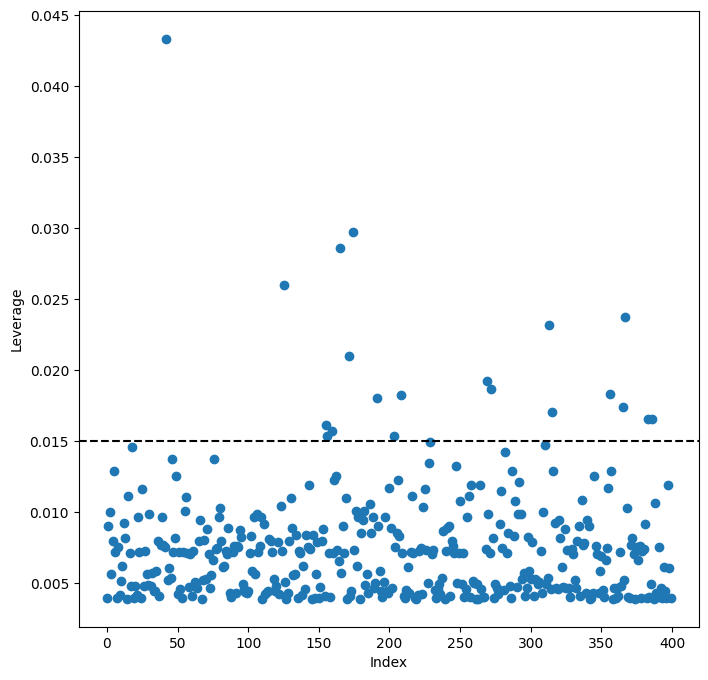

In [55]:
infl=results9.get_influence()
leverage=infl.hat_matrix_diag

fig,ax=subplots(figsize=[8,8])
ax.scatter(np.arange(X.shape[0]),leverage)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
ax.axhline(3*len(results.params)/X.shape[0], c='k', ls='--')


From the scatter plot, we identify any observations surpassing the black dotted line to be high leverage points.

In [56]:
np.argmax(leverage) # index of observation with highest leverage

42

Text(0, 0.5, 'Residuals')

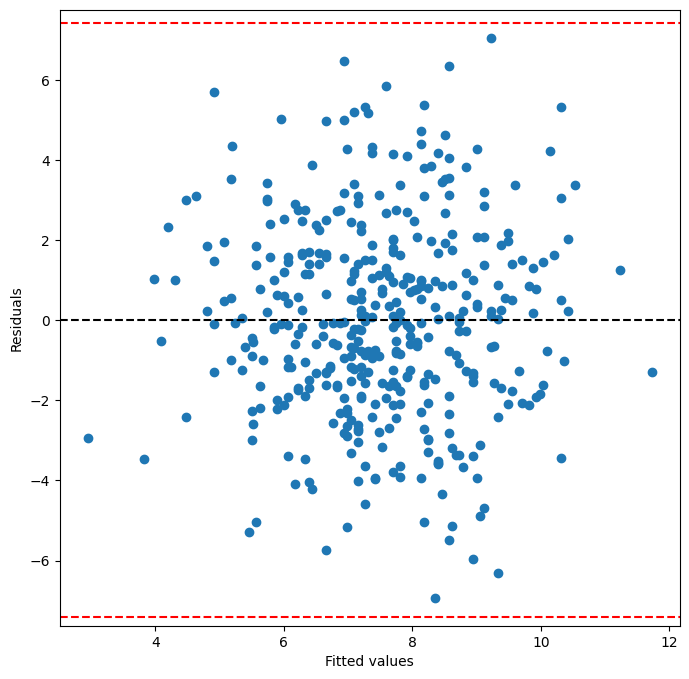

In [57]:
fig2,ax2=subplots(figsize=[8,8])
ax2.scatter(results9.fittedvalues, results9.resid)
ax2.axhline(0,c='k',ls='--')
ax2.axhline(3*np.sqrt(results9.mse_resid),c='r',ls='--')
ax2.axhline(-3*np.sqrt(results9.mse_resid),c='r',ls='--')
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Residuals')

Note that we can calculate the residual standard error by taking the square root of the residual mean square error. The two red lines mark the 3 standard error thresholds. Since all residuals are within 3 standard errors of 0, we don't identify any outliers.

In [58]:
results9.mse_resid

6.097920558687301

In [59]:
results9.mse_model

380.7001179755707

In [60]:
results9.mse_total

7.975625808897243

---
### Question 11

In this problem, we will investigate the $t$-statistic for the null hypothesis $H_0:\beta=0$ in simple linear regression without an intercept. To begin, we generate a predictor `x` and a response `y` as follows.

In [62]:
rng=np.random.default_rng(1) # seed 1
x=rng.normal(size=100) # generates 100 random numbers between -1 and 1
y=2*x+rng.normal(size=100)

a. Perform a simple linear regression of `y` onto `x` without an intercept. Report the coefficient estimate $\hat{\beta}$, the standard error of this coefficient estimate, and the $t$ statistic and $p$-value associated with the null hypothesis $H_0:\beta=0$. Comment on these results. (You can perform regression without an intercept using the keyword arguments `intercept=False` to `ModelSpec()`).

Text(0, 0.5, 'y')

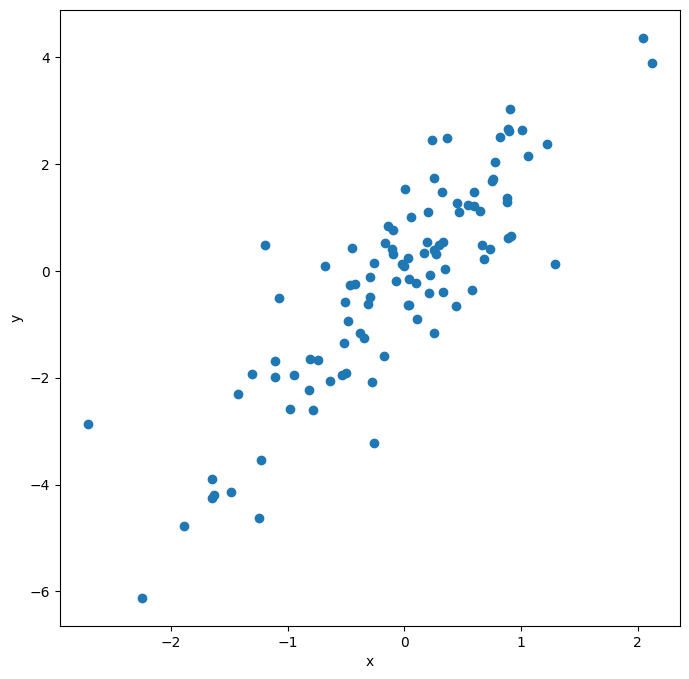

In [67]:
fig,ax=subplots(figsize=[8,8])
ax.scatter(x,y)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [71]:
X=pd.DataFrame({'x':x})
model10=sm.OLS(y,X)
results10=model10.fit()
results10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.743
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                              285.6
Date:                Sat, 12 Jul 2025   Prob (F-statistic):                    6.23e-31
Time:                        17:19:44   Log-Likelihood:                         -141.35
No. Observations:                 100   AIC:                                      284.7
Df Residuals:                      99   BIC:                                      287.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.9762      0.117     16.898      0.000       1.744       2.208
==============================================================================
Omnibus:                        1.376   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.503   Jarque-Bera (JB):                0.847
Skew:                           0.121   Prob(JB):                        0.655
Kurtosis:                       3.381   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
# or by using a transform

design=MS(['x'],intercept=False)
X10=design.fit_transform(x)
X

IndexError: tuple index out of range